# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis
from vmc import run_experiment

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)
#figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 0.1

h = 1e-7

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [4]:
alpha_min = 0.3
alpha_max = 0.9
num_alphas = 31

parameter_names = ["alpha"]

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [5]:
num_particles = 1
num_dimensions = 1

num_samples = int(4e6)
num_thermalization_steps = int(num_particles * 2000)

num_local_energies = 0

In [6]:
kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [7]:
solver_analytical = PyMetropolisAlgorithm(num_particles)
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, mass, omega, spread=step_length)
hamiltonian_analytical = PyHarmonicOscillator()
sampler_analytical = PySampler(
    wavefunction_analytical, hamiltonian_analytical,
    solver_analytical, num_local_energies)

In [8]:
solver_approximate = PyMetropolisAlgorithm(num_particles)
wavefunction_approximate = PySimpleGaussianNumerical(
    num_particles, num_dimensions, mass, omega, h=h, spread=step_length)
hamiltonian_approximate = PyHarmonicOscillator()
sampler_approximate = PySampler(
    wavefunction_approximate, hamiltonian_approximate,
    solver_approximate, num_local_energies)

In [9]:
df_analytical = run_experiment(
    sampler_analytical, wavefunction_analytical, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:20<00:00,  1.48it/s]


In [10]:
df_approximate = run_experiment(
    sampler_approximate, wavefunction_approximate, alphas,
    parameter_names, **kwargs)

100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


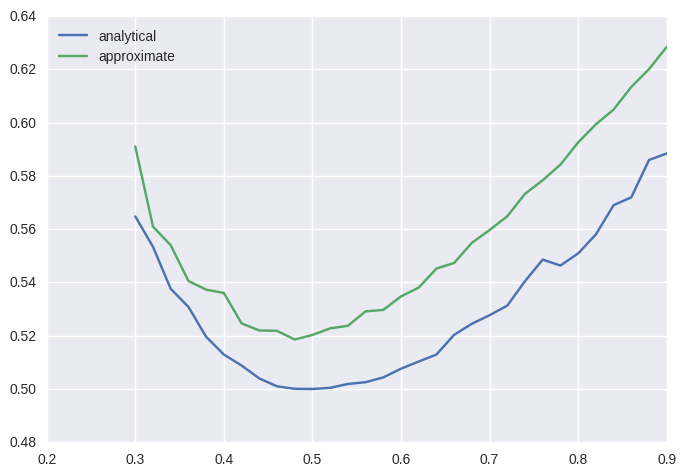

In [11]:
plt.plot(df_analytical["alpha"], df_analytical["energy"], label="analytical")
plt.plot(df_approximate["alpha"], df_approximate["energy"], label="approximate")
plt.legend(loc="best")
plt.show()

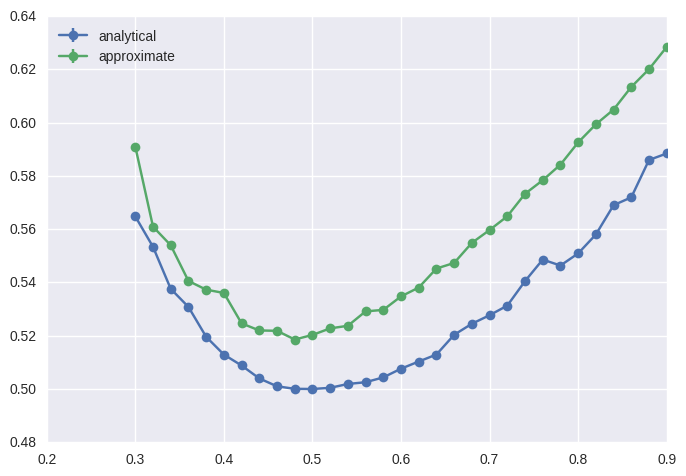

In [12]:
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

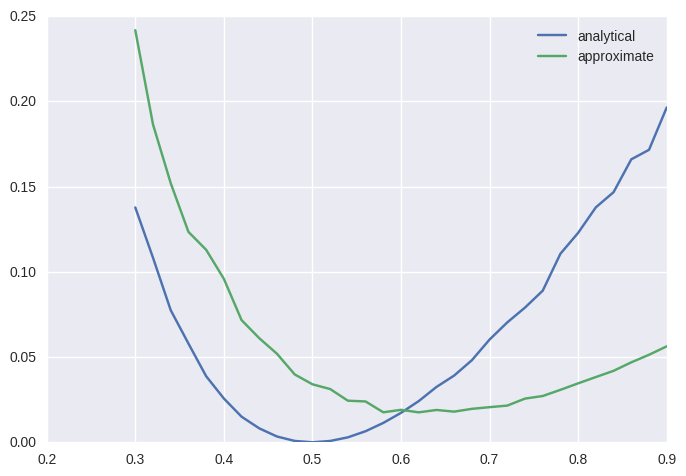

In [13]:
plt.plot(
    df_analytical["alpha"], df_analytical["variance"]/num_particles,
    label="analytical")
plt.plot(
    df_approximate["alpha"], df_approximate["variance"]/num_particles,
    label="approximate")
plt.legend(loc="best")
plt.show()

In [14]:
display(df_analytical)

,alpha,energy,variance,acceptance
0,0.30,0.564789,0.137732,0.978180
1,0.32,0.553359,0.108229,0.977385
2,0.34,0.537604,0.077472,0.976663
3,0.36,0.530805,0.057915,0.975789
4,0.38,0.519587,0.038757,0.975234
5,0.40,0.512923,0.025675,0.974911
6,0.42,0.508822,0.015000,0.973887
7,0.44,0.503968,0.008156,0.973464
8,0.46,0.501011,0.003378,0.973258
9,0.48,0.500069,0.000794,0.972497


In [15]:
display(df_approximate)

,alpha,energy,variance,acceptance
0,0.30,0.590993,0.241705,0.977873
1,0.32,0.560930,0.186398,0.977590
2,0.34,0.553959,0.151968,0.976641
3,0.36,0.540546,0.123404,0.976218
4,0.38,0.537288,0.112894,0.975311
5,0.40,0.536048,0.095875,0.974460
6,0.42,0.524639,0.071635,0.974222
7,0.44,0.521973,0.061029,0.973718
8,0.46,0.521843,0.051901,0.972790
9,0.48,0.518578,0.039783,0.972633


def exact_energy(alpha, omega, mass, num_particles, num_dimensions):
    first_term = hbar**2*num_dimensions*alpha*num_particles/float(mass)
    second_term = 0.5*mass*omega**2*num_particles*(1.0/(4.0*alpha))*num_dimensions
    third_term = -2*hbar**2*alpha**2*num_particles/float(mass)*(1.0/(4.0*alpha))*num_dimensions

    return first_term + second_term + third_term

In [16]:
energy_exact = hamiltonian_analytical.compute_exact_energy(
    wavefunction_analytical, alphas=alphas.ravel())
#energy_exact = np.zeros(num_alphas)

#for i in range(num_alphas):
#    energy_exact[i] = hamiltonian_analytical.compute_exact_energy(
#        wavefunction_analytical)

/home/schoyen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  from ipykernel import kernelapp as app


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.fill_between(
    alphas.ravel(), min(energy_exact), energy_exact, alpha=0.5)
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="VMC analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="VMC approximate", fmt="o-")
plt.legend(loc="best")
plt.show()